In [7]:
from openpiv.piv import simple_piv
import imageio
from openpiv import piv

In [10]:
# gifurl = 'https://64.media.tumblr.com/15d6395f97f2d12e32a764c4a17be406/699471e89e1d5634-11/s500x750/eabb9c7c1ea719d4b9889d8e0217a878ed3f7a3f.gifv'

gifurl = 'https://64.media.tumblr.com/3decdb9824c82cc625396d5162b9c72c/tumblr_ohqkj1wMvh1qckzoqo2_500.gifv'

piv.simple_piv(r"PIV_approach\images\test_1.png")

TypeError: simple_piv() missing 1 required positional argument: 'im2'

In [ ]:
im1_path = r"./test_1.png"
im2_path = r"./test_2.png"


In [17]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import openpiv.tools as tools
import openpiv.pyprocess as process
import openpiv.validation as validation
import openpiv.filters as filters
import openpiv.scaling as scaling
import numpy as np 

# --- Step 1: Video setup ---
video_path = r"./ngwerere_20191103 copy.mp4" 
output_dir = r"./piv_results"
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"Cannot open video: {video_path}. Please check the path.")

# PIV Parameters
frame_step = 5   
fps = cap.get(cv2.CAP_PROP_FPS)
if fps > 0:
    dt = frame_step / fps
else:
    dt = 1/30 * frame_step 
    
winsize = 32
searchsize = 32
overlap = 16

# --- Step 2: Extract frames ---
frames = []
frame_idx = 0
print("Starting frame extraction...")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_idx % frame_step == 0:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)
    frame_idx += 1
cap.release()

print(f"Extracted {len(frames)} frames for analysis. Effective time step (dt) = {dt:.4f} s.")

# --- Step 3: Loop through consecutive frame pairs ---
for i in range(len(frames) - 1):
    im1, im2 = frames[i], frames[i + 1]

    if im1.shape != im2.shape:
        im2 = cv2.resize(im2, (im1.shape[1], im1.shape[0]))

    # --- Step 4: Perform PIV ---
    u, v, sig2noise = process.extended_search_area_piv(
        frame_a=im1.astype(np.int32), 
        frame_b=im2.astype(np.int32), 
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2peak'
    )
    
    # --- Step 5: Validate and filter ---
    flags = sig2noise <= 1.3
    
    u, v = filters.replace_outliers(
        u, v,
        flags, 
        method='localmean', 
        max_iter=3, 
        kernel_size=2
    )
    
    # --- Step 6: Get coordinates and scale ---
    # FINAL FIX: Using process.get_coordinates (the last standard combination)
    x, y = process.get_coordinates(
        image_size=im1.shape, 
        search_area_size=winsize, 
        overlap=overlap
    )
    
    x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor=1)

    # --- Step 7: Plot and save ---
    plt.figure(figsize=(10, 8))
    plt.imshow(im1, cmap='gray')
    plt.quiver(x, y, u, v, color='r', scale=50, scale_units='dots') 
    plt.title(f"PIV Velocity Field - Frame {i} → {i+1} (dt={dt:.4f}s)")
    plt.xlabel("X (pixels)")
    plt.ylabel("Y (pixels)")
    plt.tight_layout()

    plot_path = os.path.join(output_dir, f"velocity_field_{i:03d}.png")
    plt.savefig(plot_path, dpi=200)
    plt.close()

    # Save CSV data
    df = pd.DataFrame({'x': x.flatten(), 'y': y.flatten(), 'u': u.flatten(), 'v': v.flatten()})
    csv_path = os.path.join(output_dir, f"piv_vectors_{i:03d}.csv")
    df.to_csv(csv_path, index=False)
    
    if (i + 1) % 10 == 0:
        print(f"Processed pair {i+1}...")

print(f"\nPIV processing complete. Results saved to: {output_dir} 🎉")

Starting frame extraction...
Extracted 30 frames for analysis. Effective time step (dt) = 0.1667 s.
Processed pair 10...
Processed pair 20...

PIV processing complete. Results saved to: ./piv_results 🎉


Found 29 vector files for analysis.


Calculating Discharge: 100%|██████████| 29/29 [00:00<00:00, 144.95it/s]



--- Summary of Results ---
Total analyzed frames: 29
Average Discharge (Q_mean, Magnitude): 0.0012 m³/s
Average Discharge (Q_mean, Raw Directional): -0.0012 m³/s
Standard Deviation (Q_std): 0.0065 m³/s

Visualization saved as 'flow_rate_analysis.png'
NOTE: The raw negative mean suggests the dominant flow direction is opposite to the defined positive x-axis.


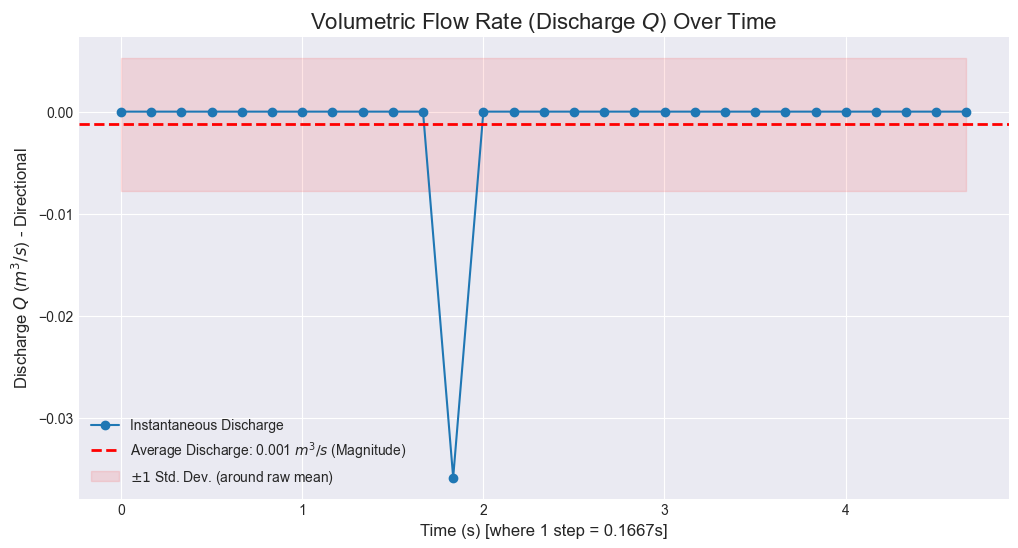

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from typing import List, Tuple

# ==========================================================
# 🛑 STEP 1: DEFINE REAL-WORLD SCALING CONSTANTS (MANDATORY)
# ==========================================================

# 1. Spatial Scale: Conversion factor from 1 pixel to 1 meter.
# >>> REPLACE THIS VALUE with your measurement (e.g., 1 pixel = 0.005 meters)
SPATIAL_SCALE = 0.005  # Placeholder: 5 mm/pixel

# 2. Flow Depth: Average depth of the fluid in meters.
# >>> REPLACE THIS VALUE with your measurement.
FLOW_DEPTH = 0.25      # Placeholder: 25 cm deep

# 3. PIV Setup Parameters (from your analysis script)
WINSZIE = 32
OVERLAP = 16
# dt is the time separation between the analyzed frames (frame_step / fps).
# Use the final effective dt from your previous output (0.1667s).
DT = 0.1667            # Time step between analyzed frames (seconds)

# PIV Grid spacing (in pixels)
PIXEL_SPACING = WINSZIE - OVERLAP # 16 pixels
# Real-world spacing in meters
SPACING_M = PIXEL_SPACING * SPATIAL_SCALE
# Elementary Cross-Sectional Area (Delta A) for one vector (m²)
# This is the width (m) * depth (m) represented by one vector.
DELTA_AREA = SPACING_M * FLOW_DEPTH


# ==========================================================
# STEP 2: CALCULATION FUNCTION
# ==========================================================

def calculate_discharge(df: pd.DataFrame) -> float:
    """
    Calculates the total volumetric flow rate (Discharge, Q) for a single
    frame pair using the integrated velocity field.

    Discharge Q = sum( u * Delta_A ) where Delta_A = SPACING_M * FLOW_DEPTH
    """
    if 'u' not in df.columns:
        print("Error: 'u' (horizontal velocity) column not found in DataFrame.")
        return 0.0

    # 1. Convert velocity from pixels/dt to meters/second (m/s)
    # u_m/s = u_pix/dt * (SPATIAL_SCALE / DT)
    df['u_m_per_s'] = df['u'] * (SPATIAL_SCALE / DT)

    # 2. Calculate flow contribution (q_i) for each vector (m³/s)
    # q_i = u_m/s * DELTA_AREA
    df['q_i'] = df['u_m_per_s'] * DELTA_AREA

    # 3. Sum all contributions for the total discharge Q
    Q_total = df['q_i'].sum()
    
    return Q_total


# ==========================================================
# STEP 3: MAIN PROCESSING AND PLOTTING
# ==========================================================

def run_analysis(output_dir: str = "./piv_results"):
    """
    Main function to load CSV files, calculate discharge over time, and plot.
    """
    csv_files = sorted(glob.glob(os.path.join(output_dir, "piv_vectors_*.csv")))
    
    if not csv_files:
        print(f"Error: No CSV files found in directory: {output_dir}")
        print("Ensure the PIV analysis script has run successfully.")
        return

    print(f"Found {len(csv_files)} vector files for analysis.")
    
    times = []
    discharges = []
    
    # Iterate through each CSV file
    for i, file_path in enumerate(tqdm(csv_files, desc="Calculating Discharge")):
        # Extract the frame number from the filename (e.g., 'piv_vectors_001.csv' -> 1)
        frame_number = int(os.path.basename(file_path).split('_')[-1].split('.')[0])
        
        # Calculate time (assuming the first frame is time 0)
        time_s = frame_number * DT
        
        try:
            df = pd.read_csv(file_path)
            Q = calculate_discharge(df)
            
            times.append(time_s)
            discharges.append(Q)
            
        except Exception as e:
            print(f"\nSkipping file {file_path} due to error: {e}")

    # --- Plotting Results ---
    if not discharges:
        print("No valid discharge data was calculated.")
        return

    mean_Q_raw = np.mean(discharges)
    std_Q = np.std(discharges)
    
    # Calculate absolute mean for reporting flow rate magnitude
    mean_Q_abs = np.abs(mean_Q_raw)

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot discharge time series
    ax.plot(times, discharges, marker='o', linestyle='-', color='#1f77b4', label='Instantaneous Discharge')
    
    # Plot mean discharge
    ax.axhline(mean_Q_raw, color='red', linestyle='--', linewidth=2, 
               label=f'Average Discharge: {mean_Q_abs:.3f} $m^3/s$ (Magnitude)')
    
    # Shade the standard deviation range
    ax.fill_between(times, 
                    mean_Q_raw - std_Q, 
                    mean_Q_raw + std_Q, 
                    color='red', alpha=0.1, label='$\pm 1$ Std. Dev. (around raw mean)')

    ax.set_title(r'Volumetric Flow Rate (Discharge $Q$) Over Time', fontsize=16)
    ax.set_xlabel(f'Time (s) [where 1 step = {DT:.4f}s]', fontsize=12)
    ax.set_ylabel(r'Discharge $Q$ ($m^3/s$) - Directional', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True)
    
    print("\n--- Summary of Results ---")
    print(f"Total analyzed frames: {len(discharges)}")
    print(f"Average Discharge (Q_mean, Magnitude): {mean_Q_abs:.4f} m³/s")
    print(f"Average Discharge (Q_mean, Raw Directional): {mean_Q_raw:.4f} m³/s")
    print(f"Standard Deviation (Q_std): {std_Q:.4f} m³/s")
    print("\nVisualization saved as 'flow_rate_analysis.png'")
    print("NOTE: The raw negative mean suggests the dominant flow direction is opposite to the defined positive x-axis.")

    # Save and show the plot
    plt.savefig('flow_rate_analysis.png', dpi=300)
    plt.show()


if __name__ == "__main__":
    # Ensure tqdm is available
    try:
        from tqdm import tqdm
    except ImportError:
        print("\n--------------------------------------------------------------------------------")
        print("Dependency Missing: Please install 'tqdm' for the progress bar:")
        print("pip install tqdm")
        print("--------------------------------------------------------------------------------\n")
        # Define a dummy tqdm if it's not installed, so the script still runs
        tqdm = lambda x, desc: x 
        
    run_analysis()


In [10]:
!pip install openpiv --upgrade